In this notebook, we explore several expansions of the score function. 
We'd like to find what is the correct theory that explains why linear score of Gaussian is a surprisingly good approximation of "exact" score than we expected. 

In [5]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# Define the transformation to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='~/Datasets', train=True, transform=transform, download=False)
test_dataset = torchvision.datasets.MNIST(root='~/Datasets', train=False, transform=transform)

# Create data loaders
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [12]:
Xtsr = torch.tensor(train_dataset.data)
Xtsr.unsqueeze_(1)
ytsr = torch.tensor(train_dataset.targets)
Xtsr = Xtsr.float() / 255.0
Xmat = Xtsr.view(Xtsr.shape[0], -1)
imgshape = tuple(Xtsr.shape[1:])
print(imgshape)

(1, 28, 28)


/tmp/ipykernel_1515734/2013224003.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtsr = torch.tensor(train_dataset.data)
/tmp/ipykernel_1515734/2013224003.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytsr = torch.tensor(train_dataset.targets)


In [53]:
# sample noised data 
def sample_Xt_batch(Xmat, batch_size, sigma=0.01):
    idx = torch.randint(Xmat.shape[0], (batch_size,))
    Xt = Xmat[idx, :]
    Xt = Xt + sigma * torch.randn_like(Xt)
    return Xt

def sample_Xtyt_batch(Xmat, ytsr, batch_size, sigma=0.01):
    idx = torch.randint(Xmat.shape[0], (batch_size,))
    Xt = Xmat[idx, :]
    Xt = Xt + sigma * torch.randn_like(Xt)
    return Xt, ytsr[idx]

In [18]:
torch.eye

<function torch._VariableFunctionsClass.eye>

In [57]:
# define score approximators 
import torch.nn.functional as F
def mean_isotropic_score(Xt, Xmean, sigma, sigma0=0.0):
    score = (Xmean - Xt) / (sigma**2 + sigma0**2)
    return score

def Gaussian_score(Xt, Xmean, Xcov, sigma):
    cov_inv = torch.inverse(Xcov + torch.eye(Xcov.shape[0], device=Xcov.device) * sigma**2)
    score = torch.matmul((Xmean - Xt), cov_inv)
    return score

def Gaussian_1stexpens_score(Xt, Xmean, Xcov, sigma):
    cov_inv_1stexp = (torch.eye(Xcov.shape[0], device=Xcov.device) - Xcov / sigma**2) / sigma**2
    score = torch.matmul((Xmean - Xt), cov_inv_1stexp)
    return score

def Gaussian_2ndexpens_score(Xt, Xmean, Xcov, sigma):
    cov_inv_2ndexp = (torch.eye(Xcov.shape[0], device=Xcov.device) - Xcov / sigma**2 + Xcov @ Xcov / sigma**4) / sigma**2
    score = torch.matmul((Xmean - Xt), cov_inv_2ndexp)
    return score

def delta_GMM_score(Xt, Xmat, sigma):
    # get squared distance matrix
    sqdist = torch.cdist(Xt, Xmat, p=2) ** 2
    # print(sqdist.shape)
    weights = F.softmax(-sqdist / (2 * sigma**2), dim=1)
    # print(weights.shape)
    score = (torch.matmul(weights, Xmat) - Xt) / sigma**2
    # print(score.shape)
    return score

In [35]:
Xmean = Xmat.mean(dim=0)
Xcov = torch.cov(Xmat.T, )

In [93]:
eigvals, eigvecs = torch.linalg.eigh(Xcov)
eigvals = torch.flip(eigvals, dims=(0,))
eigvecs = torch.flip(eigvecs, dims=(1,))
print(eigvals.shape, eigvecs.shape)

torch.Size([784]) torch.Size([784, 784])


In [94]:
eigvals[0:10].sqrt()

tensor([2.2621, 1.9343, 1.8035, 1.6857, 1.6022, 1.5079, 1.3135, 1.2331, 1.2068,
        1.1148], device='cuda:0')

In [59]:
var_avg = torch.trace(Xcov) / Xcov.shape[0]

tensor(0.0673, device='cuda:0')

In [81]:
def explained_var(vec1, vec2):
    return 1 - (vec1 - vec2).pow(2).sum() / vec1.pow(2).sum()

def explained_var_vec(vec1, vec2):
    return 1 - (vec1 - vec2).pow(2).sum(dim=-1) / vec1.pow(2).sum(dim=-1)

device = "cuda"
Xmat = Xmat.to(device)
Xmean = Xmat.mean(dim=0)
Xcov = torch.cov(Xmat.T, ) + torch.eye(Xmat.shape[1], device=Xmat.device) * 1e-5
std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()

# print(Xcov.shape)
for sigma in [0.02, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(Xmat, 2000, sigma=sigma)
    score_mean_Xt = mean_isotropic_score(Xt, Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, Xmean, sigma, sigma0=std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, Xmean, Xcov, sigma)
    score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, Xmean, Xcov, sigma)
    score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, Xmean, Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, Xmat, sigma)
    print(f"sigma={sigma}")
    for name, score in [("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ]:
        exp_var_vec = explained_var_vec(score_gmm_Xt, score)
        exp_var_rev_vec = explained_var_vec(score, score_gmm_Xt)
        print(f" {name}\tExp.Var.{exp_var_vec.mean().item()} "\
              f"\t rev Exp.Var.={exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")
    

sigma=0.02
 mean isotropic	Exp.Var.-168.12448120117188 	 rev Exp.Var.=0.006320248823612928 
 mean + std isotropic	Exp.Var.0.005877698305994272 	 rev Exp.Var.=-178.3860321044922 
 gaussian	Exp.Var.0.33727413415908813 	 rev Exp.Var.=-1.0894079208374023 
 gaussian 1st expansion	Exp.Var.-5973272064.0 	 rev Exp.Var.=-9.337068007653215e-08 
 gaussian 2nd expansion	Exp.Var.-6.41579878214271e+17 	 rev Exp.Var.=-5.960464760645934e-11 
sigma=0.1
 mean isotropic	Exp.Var.-5.765767574310303 	 rev Exp.Var.=0.13727469742298126 
 mean + std isotropic	Exp.Var.0.13009513914585114 	 rev Exp.Var.=-6.02311897277832 
 gaussian	Exp.Var.0.6580402851104736 	 rev Exp.Var.=0.48378926515579224 
 gaussian 1st expansion	Exp.Var.-374124.03125 	 rev Exp.Var.=-4.0521503251511604e-05 
 gaussian 2nd expansion	Exp.Var.-63862767616.0 	 rev Exp.Var.=4.5865775177844625e-08 
sigma=0.2
 mean isotropic	Exp.Var.-0.6815426349639893 	 rev Exp.Var.=0.38252654671669006 
 mean + std isotropic	Exp.Var.0.3728720247745514 	 rev Exp.Var

In [132]:
eigvals, eigvecs = torch.linalg.eigh(Xcov)
EPS = 1e-6
eigvals = torch.flip(eigvals, dims=(0,))
eigvecs = torch.flip(eigvecs, dims=(1,))
Xcov_half = eigvecs @ torch.diag((eigvals + EPS).sqrt()) @ eigvecs.T
assert torch.allclose(Xcov, Xcov_half @ Xcov_half, atol=1e-5)

In [ ]:
def explained_var(vec1, vec2):
    return 1 - (vec1 - vec2).pow(2).sum() / vec1.pow(2).sum()

def explained_var_vec(vec1, vec2):
    return 1 - (vec1 - vec2).pow(2).sum(dim=-1) / vec1.pow(2).sum(dim=-1)

device = "cuda"
Xmat = Xmat.to(device)
Xmean = Xmat.mean(dim=0)
Xcov = torch.cov(Xmat.T, )
std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()

# print(Xcov.shape)
for sigma in [0.02, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10.0]:    
    # sample according multi variate gaussian
    X0_gauss = torch.randn([2000, Xmean.shape[0]], device=device) @ Xcov_half + Xmean
    Xt = X0_gauss + sigma * torch.randn_like(X0_gauss)
    score_mean_Xt = mean_isotropic_score(Xt, Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, Xmean, sigma, sigma0=std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, Xmean, Xcov, sigma)
    score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, Xmean, Xcov, sigma)
    score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, Xmean, Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, Xmat, sigma)
    print(f"sigma={sigma}")
    for name, score in [("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ]:
        exp_var_vec = explained_var_vec(score_gmm_Xt, score)
        exp_var_rev_vec = explained_var_vec(score, score_gmm_Xt)
        print(f" {name}\tExp.Var.{exp_var_vec.mean().item()} "\
              f"\t rev Exp.Var.={exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")
    

sigma=0.02
 mean isotropic	Exp.Var.0.0580199770629406 	 rev Exp.Var.=0.11706453561782837 
 mean + std isotropic	Exp.Var.0.006828182376921177 	 rev Exp.Var.=-26848.9765625 
 gaussian	Exp.Var.0.010601254180073738 	 rev Exp.Var.=-440.0028381347656 
 gaussian 1st expansion	Exp.Var.-38160248.0 	 rev Exp.Var.=-7.97297980170697e-05 
 gaussian 2nd expansion	Exp.Var.-4095767249682432.0 	 rev Exp.Var.=5.662441626697046e-10 
sigma=0.1
 mean isotropic	Exp.Var.0.18451909720897675 	 rev Exp.Var.=0.23801252245903015 
 mean + std isotropic	Exp.Var.0.147653728723526 	 rev Exp.Var.=-46.990264892578125 
 gaussian	Exp.Var.0.1841709017753601 	 rev Exp.Var.=-7.72489595413208 
 gaussian 1st expansion	Exp.Var.-52080.26171875 	 rev Exp.Var.=-0.0020398541819304228 
 gaussian 2nd expansion	Exp.Var.-8821756928.0 	 rev Exp.Var.=3.3111275570263388e-06 
sigma=0.2
 mean isotropic	Exp.Var.0.4316820502281189 	 rev Exp.Var.=0.4693183898925781 
 mean + std isotropic	Exp.Var.0.4149687588214874 	 rev Exp.Var.=-2.9600543975

**Observations**
* Mean isotropic; Mean + std isotropic and Gaussian are good approximations; Gaussian is getting slightly better than the isotropic scores. 
* Mean + std Isotropic and Gaussian are more stable, explaining positive variance of the GMM score even at small $\sigma$. 
* Gaussian 1st and 2nd order expansion will start diverging at small $\sigma$ values, when $\sigma^2 < \lambda$ becoming far worse approximations than even isotropic. 
* When $\sigma^2$ start to be comparable with the top eigenvalues, adding 1st order and 2nd order Gaussian terms is adding more harm!

### Distance structure between noised sample and the dataset

In [133]:

for sigma in [0.02, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(Xmat, 5000, sigma=sigma)
    distmat = torch.cdist(Xt, Xmat, p=2)
    # print(f"sigma={sigma}, dist max={distmat.max().item()}, min={distmat.min().item()}, mean={distmat.mean().item()}, median={distmat.median().item()}, dist std={distmat.std().item()}")
    print(f"sigma={sigma}", end="")
    for func, name in [
                      (torch.min, "min"),
                      (torch.max, "max"),
                      (torch.median, "median"), 
                      (torch.mean, "mean"), 
                      (torch.std, "std"),]:
        if func in [torch.median, torch.min, torch.max]:
            stats_vec = func(distmat, dim=1).values
        else:
            stats_vec = func(distmat, dim=1)
        print(f" {name}={stats_vec.mean().item():.3f}", end="")
    print()

sigma=0.02 min=0.560 max=14.966 median=10.187 mean=10.177 std=1.203
sigma=0.1 min=2.799 max=15.220 median=10.567 mean=10.563 std=1.152
sigma=0.2 min=5.599 max=15.977 median=11.633 mean=11.639 std=1.043
sigma=0.5 min=13.994 max=20.584 median=17.315 mean=17.337 std=0.722
sigma=0.7 min=19.578 max=24.783 median=22.079 mean=22.101 std=0.585
sigma=1.0 min=27.978 max=31.962 median=29.783 mean=29.803 std=0.467
sigma=1.5 min=41.869 max=44.909 median=43.188 mean=43.203 std=0.372
sigma=2.0 min=55.741 max=58.381 median=56.893 mean=56.906 std=0.327
sigma=5.0 min=139.274 max=141.470 median=140.293 mean=140.300 std=0.269
sigma=10.0 min=279.070 max=281.205 median=280.100 mean=280.103 std=0.260


In [134]:
for sigma in [0.02, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(Xmat, 5000, sigma=sigma)
    distmat = torch.cdist(Xt, Xmat, p=2)**2 / sigma**2
    # print(f"sigma={sigma}, dist max={distmat.max().item()}, min={distmat.min().item()}, mean={distmat.mean().item()}, median={distmat.median().item()}, dist std={distmat.std().item()}")
    print(f"sigma={sigma}", end="")
    for func, name in [
                      (torch.min, "min"),
                      (torch.max, "max"),
                      (torch.median, "median"), 
                      (torch.mean, "mean"), 
                      (torch.std, "std"),]:
        if func in [torch.median, torch.min, torch.max]:
            stats_vec = func(distmat, dim=1).values
        else:
            stats_vec = func(distmat, dim=1)
        print(f" {name}={stats_vec.mean().item():.3f}", end="")
    print()

sigma=0.02 min=784.551 max=560838.312 median=261012.422 mean=264108.469 std=59908.164
sigma=0.1 min=783.721 max=23184.207 median=11197.188 mean=11323.918 std=2393.802
sigma=0.2 min=785.163 max=6393.518 median=3389.556 mean=3420.610 std=601.504
sigma=0.5 min=784.056 max=1694.463 median=1201.162 mean=1206.284 std=99.747
sigma=0.7 min=783.360 max=1253.478 median=996.236 mean=998.823 std=52.649
sigma=1.0 min=782.559 max=1021.553 median=887.965 mean=889.335 std=27.797
sigma=1.5 min=780.760 max=898.255 median=830.777 mean=831.457 std=14.313
sigma=2.0 min=777.607 max=852.956 median=809.997 mean=810.398 std=9.325
sigma=5.0 min=776.258 max=800.988 median=787.694 mean=787.769 std=3.038
sigma=10.0 min=779.273 max=791.248 median=785.029 mean=785.048 std=1.462


In [ ]:
import numpy as np

def find_min_elements(matrix):
    num_elements = []
    for row in matrix:
        sorted_row = np.sort(row)
        cumulative_sum = np.cumsum(sorted_row)
        min_elements = np.argmax(cumulative_sum > 0.99) + 1
        num_elements.append(min_elements)
    return num_elements

# Example usage
weights = np.array([[0.2, 0.3, 0.5], [0.1, 0.4, 0.5]])
min_elements = find_min_elements(weights)
print(min_elements)
# given a matrix of weights where each row sum up to one find 
# the minimal number of element that is required to make the sum > 0.99

In [114]:
cumulative_sum > 0.99

tensor([[False, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False,  True],
        ...,
        [False, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False,  True]], device='cuda:0')

In [119]:
min_elements

tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')

In [142]:
print("Sample probing points from original dataset + noise")
for sigma in [0.02, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(Xmat, 5000, sigma=sigma)
    distmat = torch.cdist(Xt, Xmat, p=2)
    weights = F.softmax(-distmat**2 / (2 * sigma**2), dim=1)
    weights_sorted = torch.sort(weights, dim=1, descending=True).values
    cumulative_sum = torch.cumsum(weights_sorted, dim=1)
    min_elem999 = torch.argmax((cumulative_sum > 0.999).float(), dim=1) + 1
    min_elem99 = torch.argmax((cumulative_sum > 0.99).float(), dim=1) + 1
    min_elem90 = torch.argmax((cumulative_sum > 0.90).float(), dim=1) + 1
    min_elem80 = torch.argmax((cumulative_sum > 0.80).float(), dim=1) + 1
    min_elem50 = torch.argmax((cumulative_sum > 0.50).float(), dim=1) + 1
    print(f"sigma={sigma} # of sample for pcent weight", end="")
    for numvec, name in [
                      (min_elem50, "50%"),
                      (min_elem80, "80%"),
                      (min_elem90, "90%"),
                        (min_elem99, "99%"),
                        (min_elem999, "99.9%"),
                        ]:
        # if func in [torch.median, torch.min, torch.max]:
        stats = torch.median(numvec, dim=0).values
        print(f" {name}={stats.item():.0f}", end="")
    print()

Sample probing points from original dataset + noise
sigma=0.02 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=1 99.9%=1
sigma=0.1 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=1 99.9%=1
sigma=0.2 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=1 99.9%=1
sigma=0.5 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=1 99.9%=1
sigma=0.7 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=1 99.9%=1
sigma=1.0 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=3 99.9%=11
sigma=1.5 # of sample for pcent weight 50%=4 80%=27 90%=72 99%=593 99.9%=2208
sigma=2.0 # of sample for pcent weight 50%=49 80%=394 90%=1006 99%=5987 99.9%=15452
sigma=2.5 # of sample for pcent weight 50%=262 80%=1741 90%=3894 99%=16352 99.9%=31546
sigma=3.0 # of sample for pcent weight 50%=797 80%=4281 90%=8507 99%=26963 99.9%=42734
sigma=4.0 # of sample for pcent weight 50%=2636 80%=10705 90%=18383 99%=41050 99.9%=53097
sigma=5.0 # of sample for pcent weight 50%=4970 80%=16894 90%=26323 99%=48086 99.9%=56621
sigm

In [141]:
print("Sample probing points from Gaussian approx of data + noise")
for sigma in [0.02, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 10.0]:
    X0_gauss = torch.randn([2000, Xmean.shape[0]], device=device) @ Xcov_half + Xmean
    Xt = X0_gauss + sigma * torch.randn_like(X0_gauss)
    distmat = torch.cdist(Xt, Xmat, p=2)
    weights = F.softmax(-distmat**2 / (2 * sigma**2), dim=1)
    weights_sorted = torch.sort(weights, dim=1, descending=True).values
    cumulative_sum = torch.cumsum(weights_sorted, dim=1)
    min_elem999 = torch.argmax((cumulative_sum > 0.999).float(), dim=1) + 1
    min_elem99 = torch.argmax((cumulative_sum > 0.99).float(), dim=1) + 1
    min_elem90 = torch.argmax((cumulative_sum > 0.90).float(), dim=1) + 1
    min_elem80 = torch.argmax((cumulative_sum > 0.80).float(), dim=1) + 1
    min_elem50 = torch.argmax((cumulative_sum > 0.50).float(), dim=1) + 1
    print(f"sigma={sigma} # of sample for pcent weight", end="")
    for numvec, name in [
                      (min_elem50, "50%"),
                      (min_elem80, "80%"),
                      (min_elem90, "90%"),
                      (min_elem99, "99%"),
                      (min_elem999, "99.9%"),
                        ]:
        # if func in [torch.median, torch.min, torch.max]:
        stats = torch.median(numvec, dim=0).values
        print(f" {name}={stats.item():.0f}", end="")
    print()

sigma=0.02 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=1 99.9%=1
sigma=0.1 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=1 99.9%=1
sigma=0.2 # of sample for pcent weight 50%=1 80%=1 90%=1 99%=1 99.9%=1
sigma=0.5 # of sample for pcent weight 50%=1 80%=1 90%=2 99%=3 99.9%=6
sigma=0.7 # of sample for pcent weight 50%=1 80%=2 90%=3 99%=10 99.9%=29
sigma=1.0 # of sample for pcent weight 50%=2 80%=6 90%=13 99%=92 99.9%=365
sigma=1.5 # of sample for pcent weight 50%=10 80%=76 90%=207 99%=1599 99.9%=5124
sigma=2.0 # of sample for pcent weight 50%=73 80%=590 90%=1453 99%=7923 99.9%=18585
sigma=2.5 # of sample for pcent weight 50%=343 80%=2144 90%=4616 99%=17819 99.9%=33004
sigma=3.0 # of sample for pcent weight 50%=882 80%=4658 90%=9107 99%=27806 99.9%=43383
sigma=4.0 # of sample for pcent weight 50%=2707 80%=11016 90%=18802 99%=41170 99.9%=53140
sigma=5.0 # of sample for pcent weight 50%=5047 80%=16982 90%=26348 99%=48182 99.9%=56643
sigma=10.0 # of sample for pcent weight 50%=1439

Observation:
* For MNIST dataset, at sigma level $\sigma<=0.7$ effectively the delta GMM score is generated by a single data point! 
 Kind of make sense that at this moment the Gaussian approximation fails miserabley. 
* If we sample probing points from a Gaussian, the score is slightly more distributed, at lower $\sigma$ level it still has multiple source of influence. 

In [63]:
rad_vec = (Xmat - Xmean).pow(2).sum(dim=1).sqrt()
print(rad_vec.max())
print(rad_vec.min())
print(rad_vec.mean())
print(rad_vec.std())

tensor(12.2324, device='cuda:0')
tensor(5.2739, device='cuda:0')
tensor(7.1944, device='cuda:0')
tensor(0.9824, device='cuda:0')


In [64]:
distmat = torch.cdist(Xmat, Xmat, p=2)

In [70]:
print(distmat.max())
print(distmat.mean())

tensor(16.8758, device='cuda:0')
tensor(10.1686, device='cuda:0')


### Load and Examine the EDM trained model w.r.t. scores

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.utils import save_image

In [144]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--expr", type=str, default="sampling", help="experiment name")
parser.add_argument("--dataset", type=str, default="mnist")
parser.add_argument('--seed', default=42, type=int, help='global seed')
parser.add_argument("--img_size", type=int, default=32)
parser.add_argument("--model_paths", default='', type=str, help='model paths')
# EDM models parameters
parser.add_argument('--sigma_min', default=0.002, type=float, help='sigma_min')
parser.add_argument('--sigma_max', default=80.0, type=float, help='sigma_max')
parser.add_argument('--rho', default=7., type=float, help='Schedule hyper-parameter')
parser.add_argument('--sigma_data', default=0.5, type=float, help='sigma_data used in EDM for c_skip and c_out')
# Sampling parameters
parser.add_argument('--total_steps', default=18, type=int, help='total_steps')
parser.add_argument("--eval_batch_size", type=int, default=64)
parser.add_argument("--fid_batch_size", type=int, default=64)
parser.add_argument("--sample_mode", type=str, default='fid', help='sample mode')
parser.add_argument('--num_fid_sample', default=10000, type=int, help='num_fid_sample')
parser.add_argument('--t_path', default='./CIFAR-10-images/train', type=str, help='source clean image path')
parser.add_argument('--begin_ckpt', default=0, type=int, help='begin_ckpt')
# Model architecture
parser.add_argument('--model_channels', default=64, type=int, help='model_channels')
parser.add_argument('--channel_mult', default=[1,2,2,2], type=int, nargs='+', help='channel_mult')
parser.add_argument('--attn_resolutions', default=[], type=int, nargs='+', help='attn_resolutions')
parser.add_argument('--layers_per_block', default=4, type=int, help='num_blocks')

config = parser.parse_args([])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.device = device
channels = {'mnist': 1, 'cifar10': 3}
config.channels = channels[config.dataset]

In [150]:
# config for MNIST
config.channel_mult = [1, 2, 3, 4]
config.model_channels = 16
config.attn_resolutions = [0,]
config.layers_per_block = 1
config.num_fid_sample = 5000
config.fid_batch_size = 1024

In [151]:
config

Namespace(expr='sampling', dataset='mnist', seed=42, img_size=32, model_paths='', sigma_min=0.002, sigma_max=80.0, rho=7.0, sigma_data=0.5, total_steps=18, eval_batch_size=64, fid_batch_size=1024, sample_mode='fid', num_fid_sample=5000, t_path='./CIFAR-10-images/train', begin_ckpt=0, model_channels=16, channel_mult=[1, 2, 3, 4], attn_resolutions=[0], layers_per_block=1, device=device(type='cuda'), channels=1)

In [209]:
import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
from train_edm import edm_sampler
from train_edm import EDM
from train_edm import create_model

def load_create_edm(config, model_path):
    # model_path = f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_75000.pth"
    unet = create_model(config)
    edm = EDM(model=unet, cfg=config)
    checkpoint = torch.load(model_path, map_location=device)
    # logger.info(f"loaded model: {model_name}")
    edm.model.load_state_dict(checkpoint)
    for param in edm.model.parameters():
        param.requires_grad = False
    edm.model.eval()
    return edm

model_path = f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_75000.pth"
unet = create_model(config)
edm = EDM(model=unet, cfg=config)
checkpoint = torch.load(model_path, map_location=device)
# logger.info(f"loaded model: {model_name}")
edm.model.load_state_dict(checkpoint)
for param in edm.model.parameters():
    param.requires_grad = False
edm.model.eval()

SongUNet(
  (map_noise): PositionalEmbedding()
  (map_augment): Linear()
  (map_layer0): Linear()
  (map_layer1): Linear()
  (enc): ModuleDict(
    (32x32_conv): Conv2d()
    (32x32_block0): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
    )
    (16x16_down): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
      (skip): Conv2d()
    )
    (16x16_block0): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
      (skip): Conv2d()
    )
    (8x8_down): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
      (skip): Conv2d()
    )
    (8x8_block0): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
     

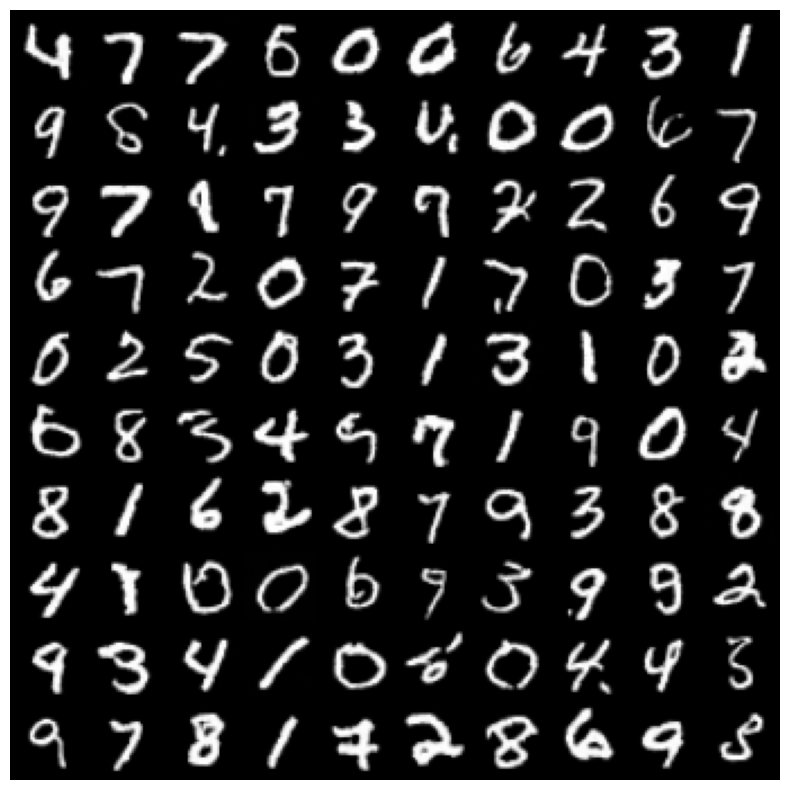

In [177]:
fid_batch_size = 100
with torch.no_grad():
    noise = torch.randn([fid_batch_size, config.channels, config.img_size, config.img_size],
                        generator=torch.cuda.manual_seed(config.seed), device=config.device)
    samples = edm_sampler(edm, noise, num_steps=config.total_steps, use_ema=False).detach().cpu()
    samples.mul_(0.5).add_(0.5)
samples = torch.clamp(samples, 0., 1.).cpu()
# samples = np.clip(samples.permute(0, 2, 3, 1).cpu().numpy() * 255., 0, 255).astype(np.uint8)
# samples = samples.reshape((-1, config.img_size, config.img_size, config.channels))
# all_samples.append(samples)

plt.figure(figsize=(10, 10))
plt.imshow((make_grid(samples*255.0, nrow=10).permute(1, 2, 0)).numpy().astype(np.uint8))
plt.axis('off')
plt.show()

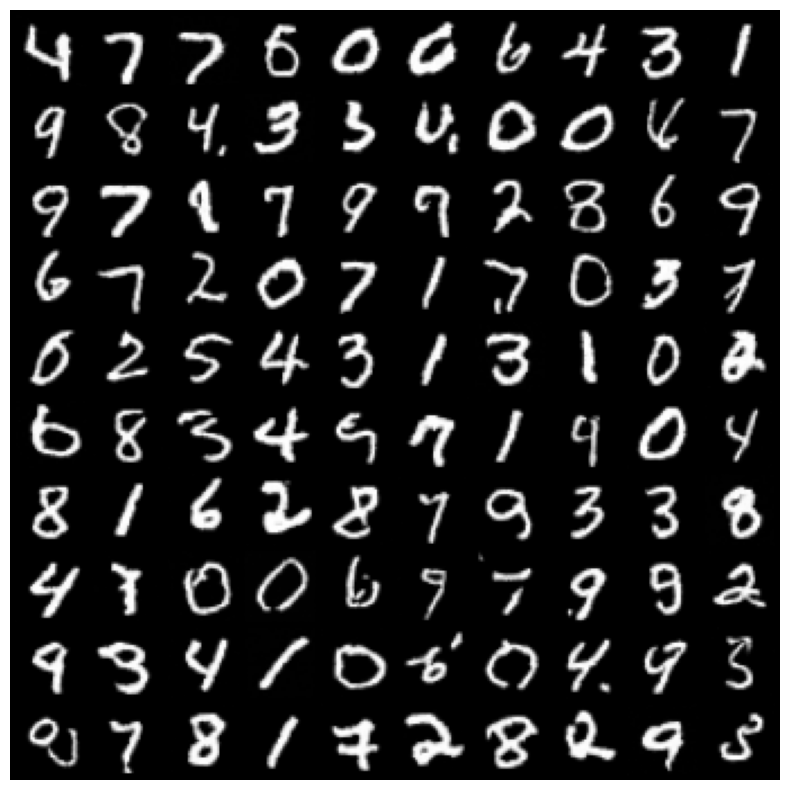

In [174]:
plt.figure(figsize=(10, 10))
plt.imshow((make_grid(samples*255.0, nrow=10).permute(1, 2, 0)).numpy().astype(np.uint8))
plt.axis('off')
plt.show()

### score checking

In [178]:
transform = transforms.Compose([
    torchvision.transforms.Resize(config.img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the MNIST dataset
train_edm_dataset = torchvision.datasets.MNIST(root='~/Datasets', train=True, transform=transform, download=False)
test_edm_dataset = torchvision.datasets.MNIST(root='~/Datasets', train=False, transform=transform)

In [185]:
edm_Xtsr = torch.stack([train_edm_dataset[i][0] for i in range(len(train_edm_dataset))])

In [186]:
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).cuda()
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )
edm_imgshape = tuple(edm_Xtsr.shape[1:])

In [ ]:
eigvals, eigvecs = torch.linalg.eigh(edm_Xcov)
eigvals = torch.flip(eigvals, dims=(0,))
eigvecs = torch.flip(eigvecs, dims=(1,))
print(eigvals.shape, eigvecs.shape)
print(eigvals[0:10].sqrt())

torch.Size([1024]) torch.Size([1024, 1024])
tensor([5.0782, 4.2297, 3.9882, 3.7294, 3.5631, 3.3024, 2.9141, 2.6671, 2.6480,
        2.4165], device='cuda:0')


In [210]:
def explained_var(vec1, vec2):
    return 1 - (vec1 - vec2).pow(2).sum() / vec1.pow(2).sum()

def explained_var_vec(vec1, vec2):
    return 1 - (vec1 - vec2).pow(2).sum(dim=-1) / vec1.pow(2).sum(dim=-1)


In [214]:
edm = load_create_edm(config, f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_25000.pth")
device = "cuda"
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).to(device)
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )
edm_imgshape = tuple(edm_Xtsr.shape[1:])
edm_std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()

# print(Xcov.shape)
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(edm_Xmat, 2000, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    score_edm = (edm_Dt.view(Xt.shape) - Xt) / (sigma**2)
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    for name, score in [("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        # ("gaussian regularize", score_gaussian_reg_Xt),
                        # ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        # ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("gmm delta", score_gmm_Xt),
                        ]:
        exp_var_vec = explained_var_vec(score_edm, score)
        exp_var_rev_vec = explained_var_vec(score, score_edm)
        print(f" {name}\tExp.Var.{exp_var_vec.mean().item()} "\
              f"\t rev Exp.Var.={exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")
    

sigma=0.01
 mean isotropic	Exp.Var.-3168.078125 	 rev Exp.Var.=0.0008527630125172436 
 mean + std isotropic	Exp.Var.-0.0016621120739728212 	 rev Exp.Var.=-166.18272399902344 
 gaussian	Exp.Var.0.2752004861831665 	 rev Exp.Var.=0.05552366003394127 
 gmm delta	Exp.Var.0.6718178391456604 	 rev Exp.Var.=0.7682291269302368 
sigma=0.02
 mean isotropic	Exp.Var.-667.5308837890625 	 rev Exp.Var.=0.002406325424090028 
 mean + std isotropic	Exp.Var.-0.00858358945697546 	 rev Exp.Var.=-47.295372009277344 
 gaussian	Exp.Var.0.5288662314414978 	 rev Exp.Var.=0.16065281629562378 
 gmm delta	Exp.Var.0.8069067001342773 	 rev Exp.Var.=0.8374648690223694 
sigma=0.05
 mean isotropic	Exp.Var.-100.06140899658203 	 rev Exp.Var.=0.014200900681316853 
 mean + std isotropic	Exp.Var.-0.047535065561532974 	 rev Exp.Var.=-7.64072322845459 
 gaussian	Exp.Var.0.6532530784606934 	 rev Exp.Var.=0.4737881124019623 
 gmm delta	Exp.Var.0.8831161260604858 	 rev Exp.Var.=0.894913375377655 
sigma=0.1
 mean isotropic	Exp.Var

In [217]:
edm = load_create_edm(config, f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_50000.pth")
device = "cuda"
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).to(device)
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )
edm_imgshape = tuple(edm_Xtsr.shape[1:])
edm_std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()

# print(Xcov.shape)
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(edm_Xmat, 2000, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    score_edm = (edm_Dt.view(Xt.shape) - Xt) / (sigma**2)
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    for name, score in [("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        # ("gaussian regularize", score_gaussian_reg_Xt),
                        # ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        # ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("gmm delta", score_gmm_Xt),
                        ]:
        exp_var_vec = explained_var_vec(score_edm, score)
        exp_var_rev_vec = explained_var_vec(score, score_edm)
        print(f" {name}\tExp.Var. {exp_var_vec.mean().item()} "\
              f"\t rev Exp.Var. {exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")
    

sigma=0.01
 mean isotropic	Exp.Var. -2924.257568359375 	 rev Exp.Var. 0.0007565445848740637 
 mean + std isotropic	Exp.Var. -0.0018216574098914862 	 rev Exp.Var. -176.51702880859375 
 gaussian	Exp.Var. 0.28616055846214294 	 rev Exp.Var. 0.026943061500787735 
 gmm delta	Exp.Var. 0.7301867604255676 	 rev Exp.Var. 0.793822169303894 
sigma=0.02
 mean isotropic	Exp.Var. -662.6802368164062 	 rev Exp.Var. 0.002609150717034936 
 mean + std isotropic	Exp.Var. -0.0076701645739376545 	 rev Exp.Var. -46.93265151977539 
 gaussian	Exp.Var. 0.5319910049438477 	 rev Exp.Var. 0.17336368560791016 
 gmm delta	Exp.Var. 0.82415372133255 	 rev Exp.Var. 0.8507366180419922 
sigma=0.05
 mean isotropic	Exp.Var. -98.98814392089844 	 rev Exp.Var. 0.01419360376894474 
 mean + std isotropic	Exp.Var. -0.04672004282474518 	 rev Exp.Var. -7.752403259277344 
 gaussian	Exp.Var. 0.6529766917228699 	 rev Exp.Var. 0.46548035740852356 
 gmm delta	Exp.Var. 0.8909317851066589 	 rev Exp.Var. 0.9015178680419922 
sigma=0.1
 mean

In [220]:
edm = load_create_edm(config, f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_75000.pth")
    
device = "cuda"
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).to(device)
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )
edm_imgshape = tuple(edm_Xtsr.shape[1:])
edm_std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()

# print(Xcov.shape)
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(edm_Xmat, 2000, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    score_edm = (edm_Dt.view(Xt.shape) - Xt) / (sigma**2)
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    for name, score in [("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        # ("gaussian regularize", score_gaussian_reg_Xt),
                        # ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        # ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("gmm delta", score_gmm_Xt),
                        ]:
        exp_var_vec = explained_var_vec(score_edm, score)
        exp_var_rev_vec = explained_var_vec(score, score_edm)
        print(f" {name}\tExp.Var. {exp_var_vec.mean().item()} "\
              f"\t rev Exp.Var. {exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")
    

sigma=0.01
 mean isotropic	Exp.Var. -2960.943603515625 	 rev Exp.Var. 0.0006625844398513436 
 mean + std isotropic	Exp.Var. -0.0023172146175056696 	 rev Exp.Var. -173.6533203125 
 gaussian	Exp.Var. 0.31422486901283264 	 rev Exp.Var. 0.03663637116551399 
 gmm delta	Exp.Var. 0.7402276396751404 	 rev Exp.Var. 0.8000717163085938 
sigma=0.02
 mean isotropic	Exp.Var. -662.3524169921875 	 rev Exp.Var. 0.002499661175534129 
 mean + std isotropic	Exp.Var. -0.008257890120148659 	 rev Exp.Var. -47.0608024597168 
 gaussian	Exp.Var. 0.5385547280311584 	 rev Exp.Var. 0.17414648830890656 
 gmm delta	Exp.Var. 0.8338063359260559 	 rev Exp.Var. 0.8589790463447571 
sigma=0.05
 mean isotropic	Exp.Var. -98.92483520507812 	 rev Exp.Var. 0.013885948807001114 
 mean + std isotropic	Exp.Var. -0.04777823016047478 	 rev Exp.Var. -7.743563652038574 
 gaussian	Exp.Var. 0.6438274383544922 	 rev Exp.Var. 0.4619082808494568 
 gmm delta	Exp.Var. 0.8944387435913086 	 rev Exp.Var. 0.904843270778656 
sigma=0.1
 mean isot

* Gaussian explains 30% var of edm, but edm only explains 0.03 var of Gaussian, showing that Gaussian has more total variance than edm?
* GMM delta explains 74% of var of EDM score, but EDM score explains 80% of GMM delta, showing that EDM score has higher variance than GMM?

In [223]:
edm = load_create_edm(config, f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_100000.pth")
device = "cuda"
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).to(device)
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )
edm_imgshape = tuple(edm_Xtsr.shape[1:])
edm_std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()

# print(Xcov.shape)
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(edm_Xmat, 5000, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    score_edm = (edm_Dt.view(Xt.shape) - Xt) / (sigma**2)
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    for name, score in [("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        # ("gaussian regularize", score_gaussian_reg_Xt),
                        # ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        # ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("gmm delta", score_gmm_Xt),
                        ]:
        exp_var_vec = explained_var_vec(score_edm, score)
        exp_var_rev_vec = explained_var_vec(score, score_edm)
        print(f" {name}\tExp.Var. {exp_var_vec.mean().item()} "\
              f"\t rev Exp.Var. {exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")
    

sigma=0.01
 mean isotropic	Exp.Var. -2924.8525390625 	 rev Exp.Var. 0.000681815727148205 
 mean + std isotropic	Exp.Var. -0.0022387802600860596 	 rev Exp.Var. -175.71603393554688 
 gaussian	Exp.Var. 0.3107598125934601 	 rev Exp.Var. 0.03561018407344818 
 gmm delta	Exp.Var. 0.7551189064979553 	 rev Exp.Var. 0.8101266622543335 
sigma=0.02
 mean isotropic	Exp.Var. -659.8417358398438 	 rev Exp.Var. 0.002586573362350464 
 mean + std isotropic	Exp.Var. -0.007975080981850624 	 rev Exp.Var. -47.2396240234375 
 gaussian	Exp.Var. 0.5392772555351257 	 rev Exp.Var. 0.17245365679264069 
 gmm delta	Exp.Var. 0.8394159078598022 	 rev Exp.Var. 0.8637501001358032 
sigma=0.05
 mean isotropic	Exp.Var. -99.01628112792969 	 rev Exp.Var. 0.013934396207332611 
 mean + std isotropic	Exp.Var. -0.0478479228913784 	 rev Exp.Var. -7.74569845199585 
 gaussian	Exp.Var. 0.6520186066627502 	 rev Exp.Var. 0.46497824788093567 
 gmm delta	Exp.Var. 0.8945126533508301 	 rev Exp.Var. 0.9051945209503174 
sigma=0.1
 mean isot

In [222]:
edm = load_create_edm(config, f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_125000.pth")
device = "cuda"
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).to(device)
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )
edm_imgshape = tuple(edm_Xtsr.shape[1:])
edm_std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()

# print(Xcov.shape)
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0]:
    Xt = sample_Xt_batch(edm_Xmat, 5000, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    score_edm = (edm_Dt.view(Xt.shape) - Xt) / (sigma**2)
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    score_gaussian1st_Xt = Gaussian_1stexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian2nd_Xt = Gaussian_2ndexpens_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    for name, score in [("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        # ("gaussian regularize", score_gaussian_reg_Xt),
                        # ("gaussian 1st expansion", score_gaussian1st_Xt), 
                        # ("gaussian 2nd expansion", score_gaussian2nd_Xt), 
                        ("gmm delta", score_gmm_Xt),
                        ]:
        exp_var_vec = explained_var_vec(score_edm, score)
        exp_var_rev_vec = explained_var_vec(score, score_edm)
        print(f" {name}\tExp.Var. {exp_var_vec.mean().item()} "\
              f"\t rev Exp.Var. {exp_var_rev_vec.mean().item()} ") #; {exp_var_rev_vec.median().item()}")
    

sigma=0.01
 mean isotropic	Exp.Var. -2905.401123046875 	 rev Exp.Var. 0.0007086676196195185 
 mean + std isotropic	Exp.Var. -0.0021292339079082012 	 rev Exp.Var. -175.33221435546875 
 gaussian	Exp.Var. 0.31747695803642273 	 rev Exp.Var. 0.038914959877729416 
 gmm delta	Exp.Var. 0.7610130310058594 	 rev Exp.Var. 0.8141971230506897 
sigma=0.02
 mean isotropic	Exp.Var. -663.48486328125 	 rev Exp.Var. 0.0026240660808980465 
 mean + std isotropic	Exp.Var. -0.00784879270941019 	 rev Exp.Var. -46.89780044555664 
 gaussian	Exp.Var. 0.5388607978820801 	 rev Exp.Var. 0.17409805953502655 
 gmm delta	Exp.Var. 0.8425134420394897 	 rev Exp.Var. 0.8664575219154358 
sigma=0.05
 mean isotropic	Exp.Var. -100.29094696044922 	 rev Exp.Var. 0.013880806043744087 
 mean + std isotropic	Exp.Var. -0.04890899360179901 	 rev Exp.Var. -7.662485599517822 
 gaussian	Exp.Var. 0.6487085223197937 	 rev Exp.Var. 0.46405184268951416 
 gmm delta	Exp.Var. 0.8954602479934692 	 rev Exp.Var. 0.9060964584350586 
sigma=0.1
 me